# IBM Quantum Experience Lab - Lab script

Please use this notebook as a template for the work that you will submit for assessment for this lab exercise.

Student Names: Parth Bhandari
               Sheila Perez 
               Charlie Solomons-Tuke

## Warm up exercise

In [17]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, Aer
from qiskit.tools.visualization import circuit_drawer
import numpy as np
import time

In [18]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)

circuit = QuantumCircuit(qr, cr)

circuit.h(qr[0])
circuit.measure(qr[0],cr[0])

backend = Aer.get_backend('qasm_simulator')

exponent = np.arange(2,20,1) # 2^25 iterations is as much as I can calulate in a reasonable amound of time.
expectation = []
for s in [2**n for n in exponent]:
    job = execute(circuit, backend, shots=s)
    result=job.result().get_counts(circuit)
    expectation.append((result['0']-result['1'])/(result['0']+result['1']))

Text(0.5, 0, 'log2(number of itterations)')

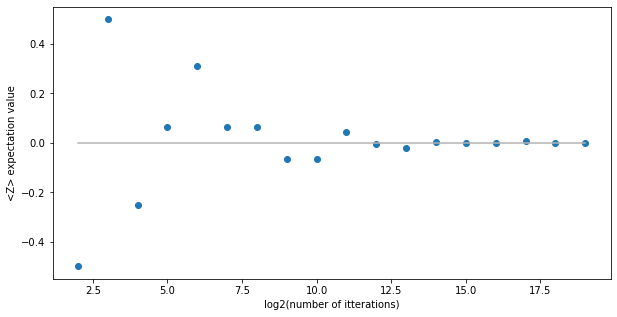

In [19]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.scatter(exponent, expectation)
ax.plot(exponent, exponent*0, c=(0.7,.7,0.7))
ax.set_ylabel('<Z> expectation value')
ax.set_xlabel('log2(number of itterations)')

# Main exercise

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

Let us first figure out what we are expecting from our circuit.

The expectation value for any pair $(\theta, \phi)$ can be calculated explicitly;

\begin{equation}
\bra{\phi}M(\theta)\ket{\phi}=\begin{pmatrix} \cos(\phi) & -i\sin(\phi) \end{pmatrix}
\begin{pmatrix} 0 & e^{-i\theta} \\ e^{i\theta} & 0 \end{pmatrix}
\begin{pmatrix} \cos(\phi) \\ i\sin(\phi) \end{pmatrix}
= i\cos(\phi)\sin(\phi)(e^{-i\theta} - e^{i\theta}) = \sin(2\phi)\sin(\theta)
\end{equation}

First, lets set up our imports, as well as some usefull functions. 

In [32]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, Aer
from qiskit.visualization import circuit_drawer
import numpy as np
import pandas as pd
import time

In [21]:
def measure_z(circuit, c_bit, shots=1024):
    """
    Takes a circuit and a classical bit, and returns the expectation value of the Z operator.
    """
    circuit.measure([0],c_bit)
    job = execute(circuit, backend, shots=shots)
    result = job.result().get_counts(circuit) 
    
    keys = list(result.keys())
    if set(keys) == set(['0','1']):
        return (result['0']-result['1'])/(result['0']+result['1'])   
    elif keys == ['0']:
        return 1.0
    elif keys == ['1']:
        return -1.0

def measure_x(circuit, c_bit, shots=1024):
    """
    Takes a circuit and a classical bit, and returns the expectation value of the X operator.
    """
    circuit.h([0])
    
    circuit.measure([0],c_bit)
    job = execute(circuit, backend, shots=shots)
    result = job.result().get_counts(circuit)
    
    keys = list(result.keys())
    if set(keys) == set(['0','1']):
        return (result['0']-result['1'])/(result['0']+result['1'])   
    elif keys == ['0']:
        return 1.0
    elif keys == ['1']:
        return -1.0


def measure_y(circuit, c_bit, shots=1024):
    """
    Takes a circuit and a classical bit, and returns the expectation value of the Y operator.
    """
    circuit.s([0])
    circuit.s([0])
    circuit.s([0]) # using S^-1 = S^3
    circuit.h([0])
    
    circuit.measure([0],c_bit)
    job = execute(circuit, backend, shots=shots)
    result = job.result().get_counts(circuit) 
    
    keys = list(result.keys()) 
    if set(keys) == set(['0','1']):
        return (result['0']-result['1'])/(result['0']+result['1'])   
    elif keys == ['0']:
        return 1.0
    elif keys == ['1']:
        return -1.0

def measure_method_2(theta, circuit, cr, shots=1024):
    """
    Takes a parameter for the matrix M, and an input state circuit with an attached a classical register, and returns <M> 
    via the standard VQE method.
    """
    xcircuit = circuit.copy()
    x = measure_x(xcircuit, cr[0], shots=shots)
    ycircuit = circuit.copy()
    circuit_drawer(ycircuit)
    y = measure_y(ycircuit, cr[0], shots=shots)
    M = np.cos(theta)*x + np.sin(theta)*y
    return M

def measure_method_1(theta, circuit, cr, shots=1024):
    """
    Takes a parameter for the matrix M, and an input state circuit with an attached a classical register, and returns <M> 
    via the unitary basis rotation method.
    """
    zcircuit = circuit.copy()
    zcircuit.p(-theta, [0])
    zcircuit.h([0])
    M = measure_z(zcircuit, cr[0], shots=shots)
    return M


Note that, when measuring, if a bit value doesn't occur in any shot it wont appear in the result dictionary. This can lead to key errors which we dodge by looking first at the keys before calculating expectations.

We also set up the registers to be used in building circuits, and our local simulator backend.

In [22]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)
backend = Aer.get_backend('qasm_simulator')

Finally, let us standardise the parameters of our measurement scheme so we can make fair comparisons between each method.

In [50]:
shots = 2**0 # Number of shots to obtain expectation value
N = 2**9 # The number of iterations used to see statistics of method

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

## Pair 1:  𝜃=𝜋/4,  𝜙=0

When $\phi=0$ the state is simply $\ket{0}$. Since this is the default state for a fresh qubit in QISKIT, we don't need to do anything to our qubit to reach the correct state.

For $\theta = \pi /4$, the observable in question is

$$ M(\pi/4) = \begin{pmatrix} 0 & \frac{1-i}{\sqrt{2}} \\ \frac{1+i}{\sqrt{2}} & 0
\end{pmatrix}$$

and from above we have that $\langle M\rangle = 0$

### Method 1

Note that $M = U(\theta)XU(\theta)^\dagger = U(\theta)HZHU(\theta)^\dagger$, so to measure M we just need to apply $HU(\theta)^\dagger$, and then measure $Z$. For $\theta = \pi/4$, $HU(\pi/4)^\dagger = HT^\dagger$

In [51]:
# Method 1

zcircuit = QuantumCircuit(qr, cr)
M1_1 = []
start=time.time()
for i in range(N):
    M1_1.append(measure_method_1(np.pi/4, zcircuit, cr, shots=shots))
t1_1 = time.time()-start

In [52]:
print(f'Method 1: \nTime elapsed for {N} iterations of {shots} shots: ', t1_1)
print('Mean:', np.mean(M1_1))
print('Std. dev.:', np.std(M1_1))

Method 1: 
Time elapsed for 512 iterations of 1 shots:  3.3807284832000732
Mean: 0.0078125
Std. dev.: 0.9999694819561995


### Method 2

We use the identity $M(\pi/4) = \frac{1}{\sqrt{2}} X + Y $, then estimate $X$ and $Y$ independently.

Below we define functions for measuring x and y given a circuit and a clasical bit to perform the measurement on.

In [39]:
# Method 2

circuit = QuantumCircuit(qr, cr)
M2_1 = []
start=time.time()
for i in range(N):
    M2_1.append(measure_method_2(np.pi/4, circuit, cr, shots=shots))
t2_1 = time.time()-start

In [40]:
print(f'Method 2: \nTime elapsed for {N} iterations of {shots} shots: ', t2_1)
print('Mean:', np.mean(M2_1))
print('Std. dev.:', np.std(M2_1))

Method 1: 
Time elapsed for 500 iterations of 4096 shots:  13.919654369354248
Mean: -0.00014017839509850494
Std. dev.: 0.015528653317294595


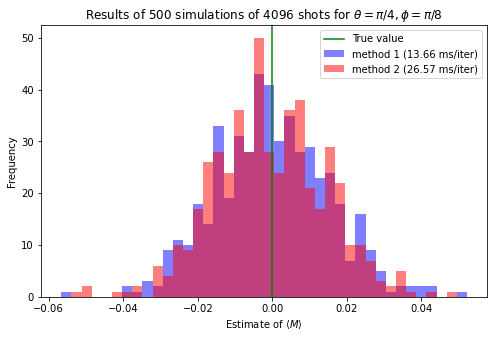

In [25]:
fig1, ax1 = plt.subplots(figsize=(8,5))
bins=np.histogram(np.hstack((M1_1,M2_1)), bins=40)[1]
ax1.hist(M1_1, bins, color='b', alpha=0.5, label=f'method 1 ({round(t1/N*1000, 2)} ms/iter)')
ax1.hist(M2_1, bins, color='r', alpha=0.5, label=f'method 2 ({round(t2/N*1000, 2)} ms/iter)')
ax1.axvline(0.0, linestyle='-', c='g', label='True value')
ax1.set_xlabel(r'Estimate of $\langle M\rangle$')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Results of {N} simulations of {shots} shots for '+r'$\theta=\pi/4, \phi=\pi/8$')
ax1.legend()

## Pair 2:  𝜃=𝜋/8,  𝜙=𝜋/4

For $\phi = \pi/4$ the input state is $\frac{1}{\sqrt{2}}(\ket{0} + i\ket{1}) = \mathrm{exp}(-i\pi/4)HU(-\pi/2)H\ket{0}$. 

The formula above gives $\langle M\rangle = \sin(\pi/8) \approx 0.3827$.

To initialise the state we use the following function:

In [26]:
def init_circuit(phi, qr, cr):
    circuit = QuantumCircuit(qr, cr)
    circuit.h([0])
    circuit.p(-2*phi, [0])
    circuit.h([0]) # Ignoring global phase
    return circuit
    

In [27]:
# Method 1

zcircuit = init_circuit(np.pi/4, qr, cr)
M1_2 = []
start=time.time()
for i in range(N):
    M1_2.append(measure_method_1(np.pi/8, zcircuit, cr, shots=shots))
t1_2 = time.time()-start


Method 1: Time elapsed for 500 iterations:  6.9725916385650635


In [ ]:
print(f'Method 1: \nTime elapsed for {N} iterations of {shots} shots: ', t1_2)
print('Mean:', np.mean(M1_2))
print('Std. dev.:', np.std(M1_2))

In [28]:
# Method 2

circuit = init_circuit(np.pi/4, qr, cr)
M2_2 = []
start=time.time()
for i in range(N):
    M2_2.append(measure_method_2(np.pi/8, circuit, cr, shots=shots))
t2_2 = time.time()-start

Method 2: Time elapsed for 500 iterations:  13.777351379394531


In [33]:
print(f'Method 2: \nTime elapsed for {N} iterations of {shots} shots: ', t2_2)
print('Mean:', np.mean(M2_2))
print('Std. dev.:', np.std(M2_2))


Statistics:
                0
count  500.000000
mean     0.384043
std      0.014185
min      0.337572
25%      0.373210
50%      0.384939
75%      0.393059
max      0.426441


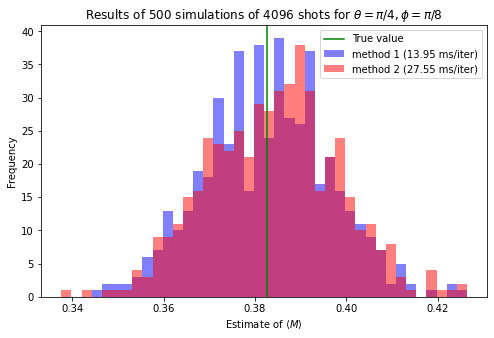

In [29]:
fig1, ax1 = plt.subplots(figsize=(8,5))
bins=np.histogram(np.hstack((M1_2,M2_2)), bins=40)[1]
ax1.hist(M1_2, bins, color='b', alpha=0.5, label=f'method 1 ({round(t1/N*1000, 2)} ms/iter)')
ax1.hist(M2_2, bins, color='r', alpha=0.5, label=f'method 2 ({round(t2/N*1000, 2)} ms/iter)')
ax1.axvline(0.3827, linestyle='-', c='g', label='True value')
ax1.set_xlabel(r'Estimate of $\langle M\rangle$')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Results of {N} simulations of {shots} shots for '+r'$\theta=\pi/4, \phi=\pi/8$')
ax1.legend()

## Time benchmarking

The time taken for each method to calculate expectation values is an important test of its usefulness. The full time taken for a given method is slightly ambiguous, as different user requirements might end up bottlenecking different parts of the calculation. 

For instance, we have assumed $M$ is of a fixed form which in turn makes the VQE decomposition very easy, and the state preparation in the basis rotation method easier also. For a more general observable $A$ we might wish to have a subroutine which performs the decomposition/finds the rotation matrix respectively, which may affect the performance. However, these tasks only need to be performed once at the start of the computation, so become irrelevant for larger numbers of iterations.

Let's assess how time taken scales with iteration number:

In [89]:
shots = np.arange(1000, 100000, 1000)
s_exps  = np.linspace(7, 17, 200)
#shots = [(2**exp)//1 for exp in s_exps]

# Method 1
zcircuit = init_circuit(np.pi/4, qr, cr)
M1 = []
t1 = []
for s in shots:
    start=time.time()
    M1.append(measure_method_1(np.pi/8, zcircuit, cr, shots=s))
    end=time.time()
    t1.append(end-start)
    
# Method 2
circuit = init_circuit(np.pi/4, qr, cr)
M2 = []
t2 = []
for s in shots:
    start=time.time()
    M2.append(measure_method_2(np.pi/8, circuit, cr, shots=s))
    end=time.time()
    t2.append(end-start)
    


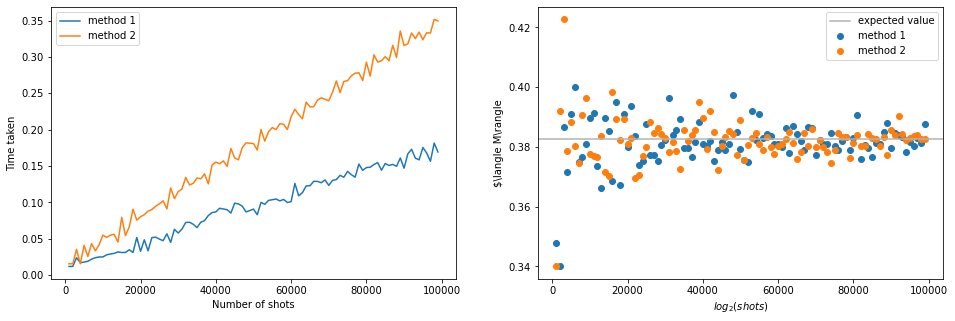

In [80]:
fig, axs = plt.subplots(1,2,figsize=(16,5))
axs[0].plot(shots,t1, label='method 1')
axs[0].plot(shots,t2, label='method 2')
axs[0].set_xlabel('Number of shots')
axs[0].set_ylabel('Time taken')
axs[0].legend()

axs[1].scatter(shots,M1, label='method 1')
axs[1].scatter(shots,M2, label='method 2')
axs[1].axhline(np.sin(np.pi/8), label='expected value', c=(.7,.7,.7))
#axs[1].set_xlabel(r'$log_2(shots)$')
axs[1].set_ylabel(r'$\langle M\rangle')
axs[1].legend()

To quantify the quality of the simulation, we have to quantify the time taken to get below a vertain error threshold. To calculate the average time taken, we can leverage the fact that the the time/shot is roughly constant:


In [83]:
tps_1 = np.mean(np.array(t1)/np.array(shots))
tps_2 = np.mean(np.array(t2)/np.array(shots))
print(tps_1, tps_2)

2.2239869411925625e-06 4.0614421241358595e-06


For calulating error at a given shot value, we need a characteristic std deviation as a function of shots:

In [105]:
#s_exps  = np.linspace(7, 14, 10)
#shots = [(2**exp)//1 for exp in s_exps]
shots_std = np.linspace(500,2000,15)
N=50

# Method 1
zcircuit = init_circuit(np.pi/4, qr, cr)
std1 = []
for s in shots_std:
    m = []
    for i in range(N):
        m.append(measure_method_1(np.pi/8, zcircuit, cr, shots=s))
    std1.append(np.std(m))
    
# Method 2
circuit = init_circuit(np.pi/4, qr, cr)
std2=[]
for s in shots_std:
    m=[]
    for i in range(N):
        m.append(measure_method_2(np.pi/8, circuit, cr, shots=s))
    std2.append(np.std(m))

        

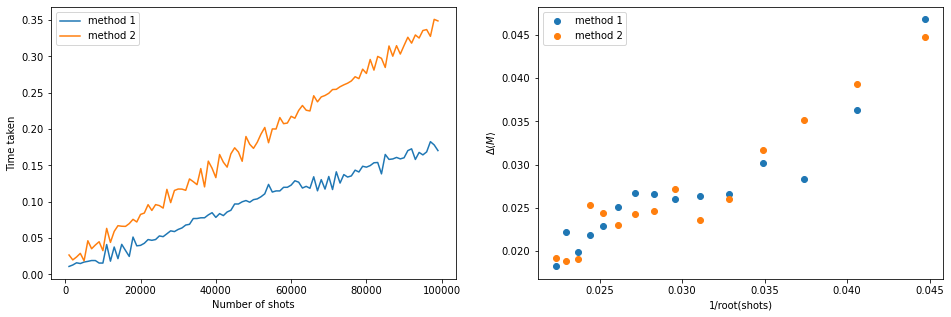

In [106]:
fig, axs = plt.subplots(1,2,figsize=(16,5))
axs[0].plot(shots,t1, label='method 1')
axs[0].plot(shots,t2, label='method 2')
axs[0].set_xlabel('Number of shots')
axs[0].set_ylabel('Time taken')
axs[0].legend()

rt_s = np.sqrt(1/np.array(shots_std))
axs[1].scatter(rt_s, std1, label='method 1')
axs[1].scatter(rt_s, std2, label='method 2')
axs[1].set_xlabel(r'1/root(shots)')
axs[1].set_ylabel(r'$\Delta\langle M\rangle$')
axs[1].legend()

In [107]:
bf1 = np.polyfit(rt_s, std1,1)
bf1


array([ 0.95813056, -0.00189648])

In [109]:
np.polyfit(rt_s, std2, 1)

array([ 1.06238567, -0.0048557 ])